# Bike Sharing Demand

## Predict demand of bike by Machine Learing

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3948/media/bikes.png" alt="Random Search for Hyper-Parameter Optimization" style="width: 720px;"/>

<p style="text-align: center;">
  <small>
    [See <a href="https://www.kaggle.com/c/bike-sharing-demand/overview">Bike Sharing Demand (Kaggle URL)</a>]
  </small>
</p>

## Introduction 
<br>

### Object

<br>

See, fork, and run a **random forest** benchmark model through Kaggle Scripts

- Period of bike rental data : 2 years
- train dataset : 19 days(1st ~ 19th) each month
- test dataset : about 10 days(20th ~ last) each month

We must predict the total count of bikes rented during 2 years for each month, hour.

<br>

### Data Fields from Capital Bikeshare(Bike-sharing Startup in Wachington D.C)     

<br>

- datetime - hourly date + timestamp (Year + Month + Day + Hour + Minutes + Seconds) 
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
  (If it is not holiday or workingday, it will be **weekend**)
- weather 

  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
  
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals (casual + registered)

$$ casual + registered = count $$

<br>

### Evaluation 

<br>

Submissions are evaluated one the Root Mean Squared Logarithmic Error (**RMSLE**). The RMSLE is calculated as

<br>

$$ RMSLE = \sqrt {\frac{1}{n}\sum\limits_{i=1}^n(log(p_i+1) - log(a_i + 1))^2} $$

## Import CSV file by using Pandas (Collecting Data)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error # RMSLE Method (Excepting for Only Root)

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [5]:
test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [6]:
print(train.shape)
train.info()

(10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
print(test.shape)
test.info()

(6493, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


 * We can know that train.csv and test.csv file(dataset) has no **NaN** in those columns.
 * There is only one 'Object' data(datetime) in dataset. So, we have to change the type for Feature Engineering.
 * Most of the data already been processed for Feature Engineering, so we don't need to for much exchange.

## Exploratory Data Analysis (EDA)

### 1. Correlation Analysis

<AxesSubplot:>

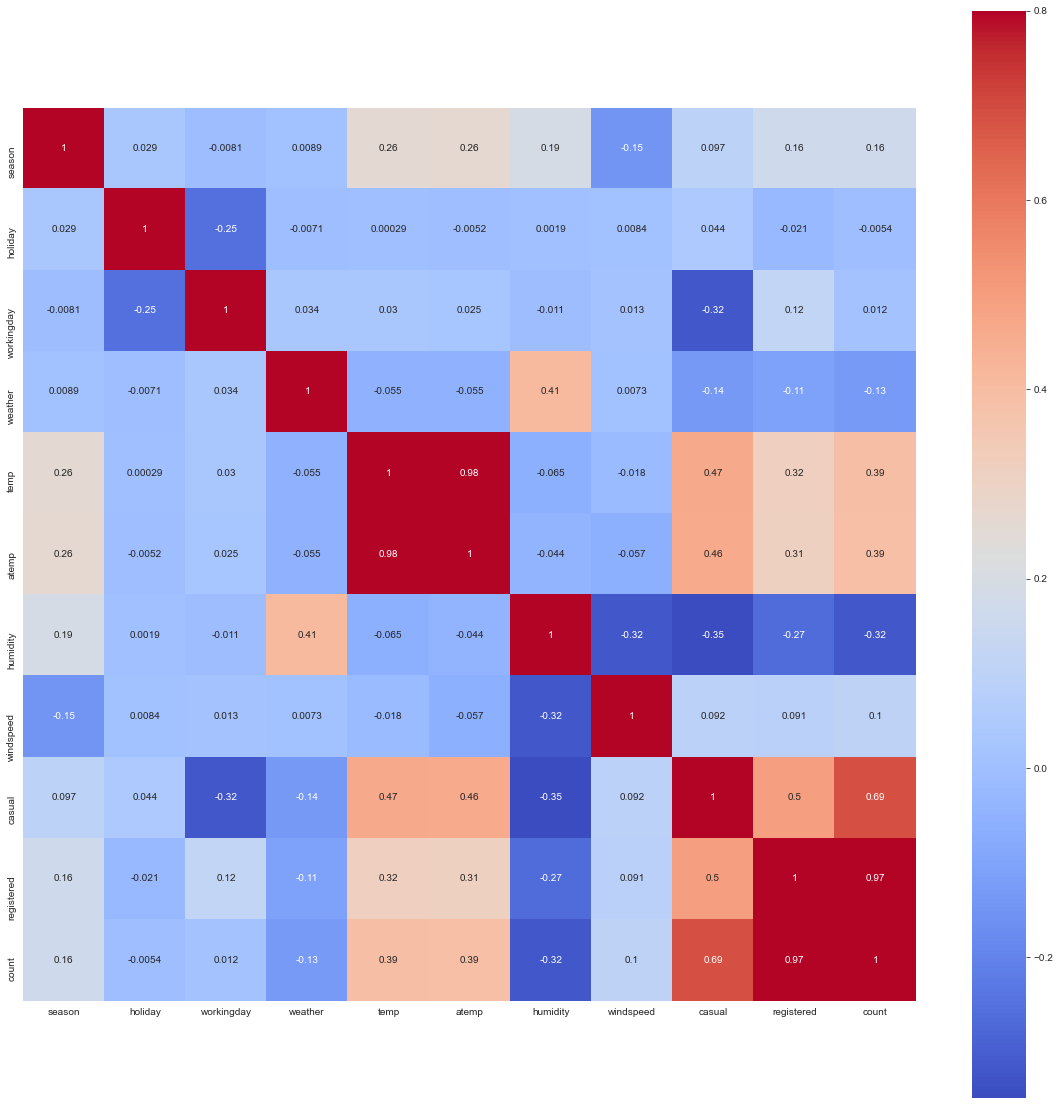

In [8]:
cols = list(train.columns)
corr = train[cols].corr()
mask = np.array(corr)

plt.figure(figsize=(20,20))
sns.heatmap(corr, vmax=0.8, square=True, annot=True, cmap="coolwarm")


<br>

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and "temp","atemp","humidity","windspeed".

<br>

* temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".



* windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"



* "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.



* "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

<br>

Because "casual" and "registration" show different correlation from above figure, we need to analyze different way and set the machine learning models.

### 2. Preprocessing 

<br>

Bike Sharing Demand conveniently has most of the data preprocessing like "season, holiday, workingday, weather" column. (Contrary to Titanic)

<br>

**Date time**

<br>

We should change the column's type **Object** to **datetime** (We alreay check type by info command). Dividing the datetime column into six different columns is the key to preprocessing the date column.

In [9]:
type(train["datetime"].iloc[0])

str

In [10]:
train["datetime"] = pd.to_datetime(train["datetime"])
type(train["datetime"].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
test["datetime"] = pd.to_datetime(test["datetime"])
type(test["datetime"].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
train["year"] = train['datetime'].dt.year
train["month"] = train['datetime'].dt.month
train["day"] = train['datetime'].dt.day
train["hour"] = train['datetime'].dt.hour
train["minute"] = train['datetime'].dt.minute
train["second"] = train['datetime'].dt.second

cols = ['datetime', 'year', 'month', 'day', 'hour', 'minute', 'second']

train[cols].head(3)

,datetime,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0


In [13]:
test["year"] = test['datetime'].dt.year
test["month"] = test['datetime'].dt.month
test["day"] = test['datetime'].dt.day
test["hour"] = test['datetime'].dt.hour
test["minute"] = test['datetime'].dt.minute
test["second"] = test['datetime'].dt.second

cols = ['datetime', 'year', 'month', 'day', 'hour', 'minute', 'second']

test[cols].head(3)

,datetime,year,month,day,hour,minute,second
0,2011-01-20 00:00:00,2011,1,20,0,0,0
1,2011-01-20 01:00:00,2011,1,20,1,0,0
2,2011-01-20 02:00:00,2011,1,20,2,0,0


### 2. Explore (Visualization)

After preprocessing, explore and visualize the data.

Suggest some of ideas for improving ML performance.

#### 1) datetime (year - month - day - hour - minute - second)

**Idea**
1. Minutes and seconds is not a key factor in this data. Cause "datetime" column is divided by hour only.
2. **Day** data should not be included in in X_train features. After the 19th of every month, it means our target (y_train). So it can make the ML overfit.
3. The date, hour, month seems to have an important influence on renting a bicycle. For example weekend vs weeday, afternoon vs morning for commute, hot summer vs cold winter and so on.

<AxesSubplot:xlabel='second', ylabel='count'>

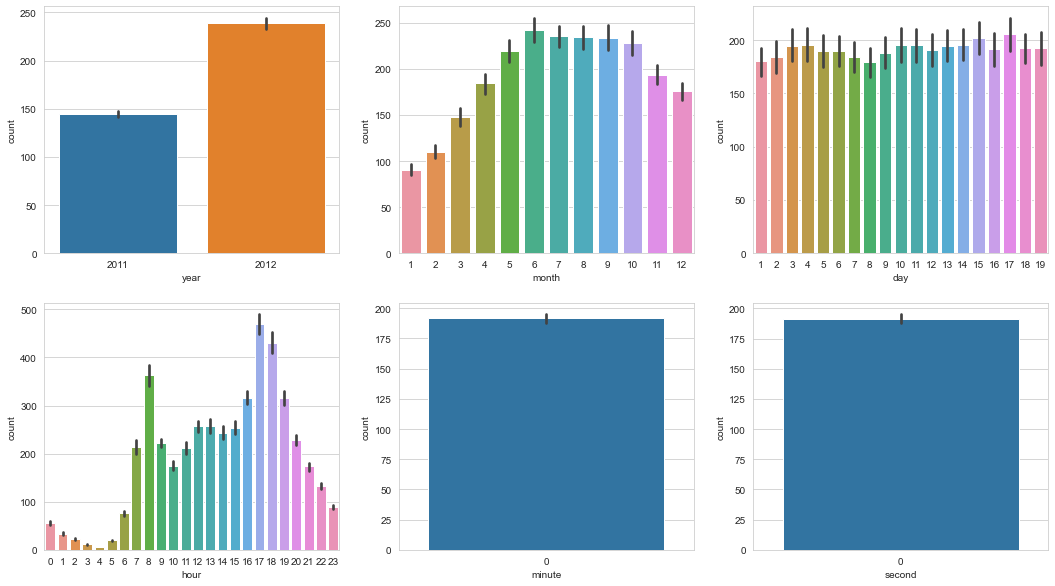

In [14]:
figure, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,10)

sns.barplot(data = train, x = "year", y = 'count', ax=ax1)
sns.barplot(data = train, x = "month", y = 'count', ax=ax2)
sns.barplot(data = train, x = "day", y = 'count', ax=ax3)
sns.barplot(data = train, x = "hour", y = 'count', ax=ax4)
sns.barplot(data = train, x = "minute", y = 'count', ax=ax5)
sns.barplot(data = train, x = "second", y = 'count', ax=ax6)

In [15]:
train.info() # Check the history : datetime(object → datetime) → year, month, day, hour, minute, second (int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
 16  minute      10886 non-

456


<AxesSubplot:xlabel='year_month', ylabel='count'>

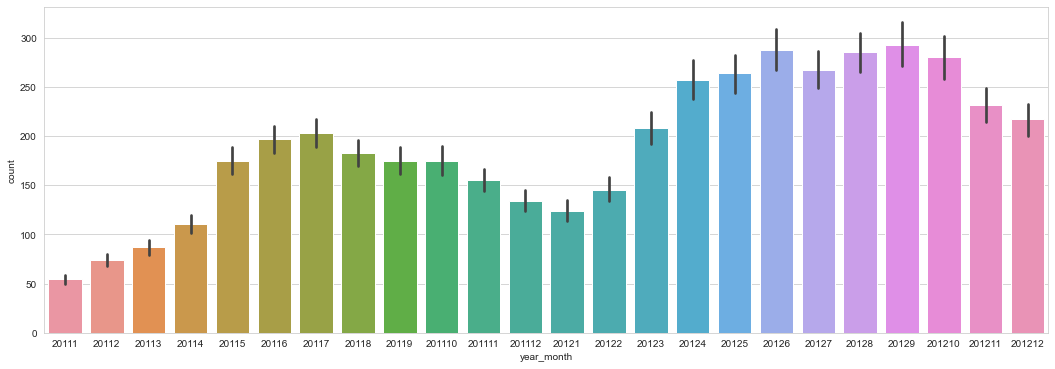

In [16]:
train["year_month"] = train["year"].astype("str") + train["month"].astype("str")

print(train["year_month"].value_counts()[0])

plt.figure(figsize=(18,6))
sns.barplot(data=train, x="year_month", y="count")

In [17]:
train["year_season"] = train["year"].astype("str") + train["season"].astype("str")
train[["year", "season", "year_season"]].head()

,year,season,year_season
0,2011,1,20111
1,2011,1,20111
2,2011,1,20111
3,2011,1,20111
4,2011,1,20111


<AxesSubplot:xlabel='year_season', ylabel='count'>

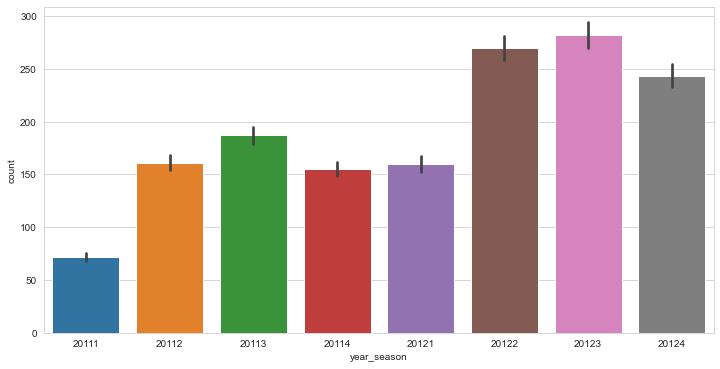

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(data = train, x = "year_season", y = 'count')

#### One Hot Encoding for "year_seaon"

In [19]:
dummies = pd.get_dummies(train['year_season'], prefix='year_season')
dummies
train = pd.concat([train, dummies], axis=1)

In [20]:
cols = ['year_season', 'year_season_20111', 'year_season_20112', 'year_season_20113',
       'year_season_20114', 'year_season_20121', 'year_season_20122',
       'year_season_20123', 'year_season_20124']
train[cols].head()

,year_season,year_season_20111,year_season_20112,year_season_20113,year_season_20114,year_season_20121,year_season_20122,year_season_20123,year_season_20124
0,20111,1,0,0,0,0,0,0,0
1,20111,1,0,0,0,0,0,0,0
2,20111,1,0,0,0,0,0,0,0
3,20111,1,0,0,0,0,0,0,0
4,20111,1,0,0,0,0,0,0,0


**The chart shows that** 
  - figure 1. [year-count]
  : Bike rentals is growing steadily 2012 than 2011
  - figure 2. [month-count]
  : It looks like Bike rental growing-up in summer than winter. But we should think about that is **mean** value. So, we should check year-month bike rental trends.
  - figure 3. [day-count]
  : There is no data after each month 19th day. Because after 19th's bike rentals is in `test` dataset.
  - figure 4. [hour-count]
  : There is no bike rentals in dawn and early morning. And we can see that bike rentals are increasing dramatically during commute time.
  - figure 5,6 [minute-count], [second-count]
  : There is no any help from data about minutes and seconds.There is no need to consider about 2 factors.

<AxesSubplot:xlabel='year_month', ylabel='count'>

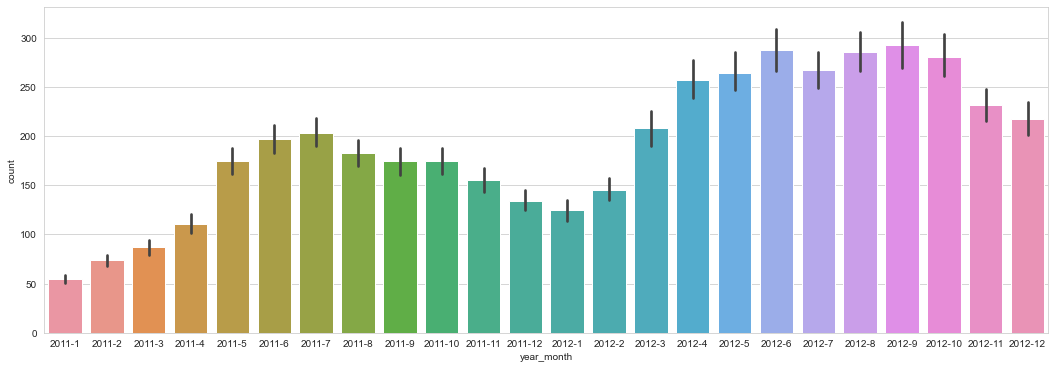

In [21]:
train["year_month"] = train["year"].astype("str") + "-" + train["month"].astype("str")
plt.figure(figsize = (18, 6))
sns.barplot(data = train, x = "year_month", y = "count")

**Conclusion**

1. Drop the column "datetime_minute" and "datetime_second"


2. As i said above, day data after 19th are in the test. In this case if we use the "day" column for Machine Learing Algorithm feature, it could lead to **Overfitting**. So, we cannot use "day" column.


3. We can see that the "hour" column is important factor feature.

### Q7-2) 이 시각화로 발견할 수 있는 사실은 어떤 게 있을까요? 그리고 앞서 우리의 예상과 어떤 차이가 있나요?

1. 가장 처음 알 수 있는 것은, 이 회사가 전반적으로 성장하고 있다는 것입니다. (=자전거 대여량이 올라감) 2011년도 1월에 비해, 2012년도 12월에는 자전거 대여량이 현격하게 증가하는 것이 보입니다.
2. 그리고 월(```datetime-month```)만 놓고 보면 얼핏 12월이 1월보다 자전거 대여량이 높아 보였지만, 연도와 월을 합쳐서 보니 12월이 1월보다 자전거 대여량이 높은 이유는 트렌드의 차이라는 것을 알 수 있습니다. 즉, 12월이라고 자전거를 1월보다 많이 빌려야 하는 특별한 이유는 보이지 않습니다.

### Q7-3) 이 사실을 통해 어떻게 예측 모델을 개선할 수 있을까요?

1. 가장 큰 사실은, 머신러닝 모델이 이 트렌드를 파악하기 어렵다는 것입니다. 가령 머신러닝 모델 입장에서는 월(```datetime-month```)을 feature로 받았을 경우 단순히 "12월이 1월보다 자전거 대여량이 높으니 12월일 경우는 자전거 대여량을 높게 예측해야겠다."라고 오해할 수도 있습니다.
2. 그런 의미에서, 이 트렌드의 개념을 반영해줄 필요가 있습니다. 이는 여러가지 방법이 있는데, 1) 트렌드에 맞게 자전거 대여량(```count```)을 보정해주거나, 2) 2011년 1월부터 2012년 12월까지의 24개의 기간을 머신러닝 모델에 넣어주는(즉, 연과 월을 따로 넣지 않고 붙여서 함께 넣어주는) 방법이 있을 것으로 보입니다.
3. 아니면 정 반대로, 이 트렌드를 이해하지 못하고 오해할 소지가 있다면 이를 사전에 배제해주는 것도 방법입니다. 이를 위한 가장 쉬운 방법은 월(```datetime-month```)을 feature에서 제거해주는 것입니다.

#### 2) weather

<AxesSubplot:xlabel='weather', ylabel='count'>

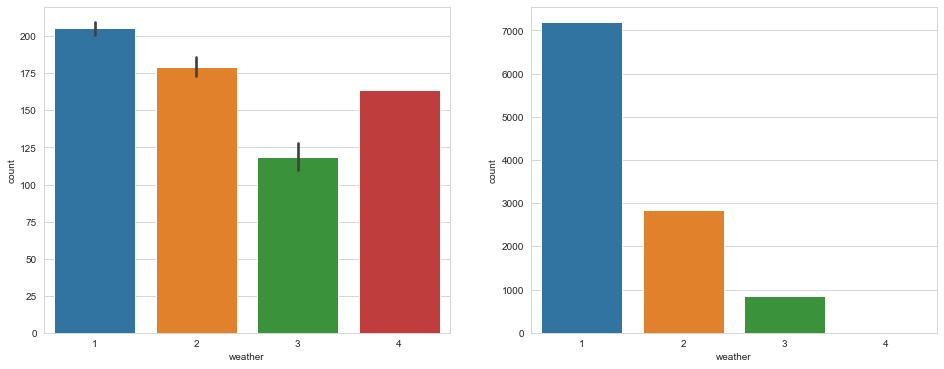

In [22]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)

figure.set_size_inches(16,6)

sns.barplot(data=train, x='weather', y='count', ax=ax1)
sns.countplot(data=train, x='weather', ax=ax2)

In [23]:
print(train["weather"].value_counts())
test["weather"].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


1    4221
2    1710
3     560
4       2
Name: weather, dtype: int64

**Expectation**

 First of all, it would be that the worse weather is the lower number of bike rental. People will rent a bike less for 4 than for 1(clean weather).

The chart shows that 
  - figure 1. [wether-count(mean)]
  : As previously thought, we can see that the worse the weather is the lower the number of bike rentals. In which the weather value is 2 more than 3 and 1 more than 2 rents a bicycle. But the weather value 4 is sharply increase than 3(**why?**).
  - figure 2. [wether(counts)-count]
  : We can find the reason at the figure 2 why weather value 4 increased sharply. The people in Wachinton.DC didn't rent bike in bad weather 4. Looking at the absence of the confidence interval in Figure 1, we can see that weather 4 in Figure 2 has only 1 count.

#### feature engineering (weather)

**Conclusion**

1. If the value of the weather column is 4, it is very insufficient. (There is only one based on 10,886 train data). Therefore, if this data is removed or if the weather column value changed 4 to 3, we could expect there to be a performance boost.

2. We can also expect performance boost by doing weather data's One Hot Encoding cause that data is categorical.

In [24]:
train["weather_encoded"] = train["weather"].copy()
train.loc[train["weather"] == 4,"weather_encoded"] = 3

train.loc[train["weather"] == 4, ["weather", "weather_encoded"]]

,weather,weather_encoded
5631,4,3


#### 3) windspeed

C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='windspeed', ylabel='count'>

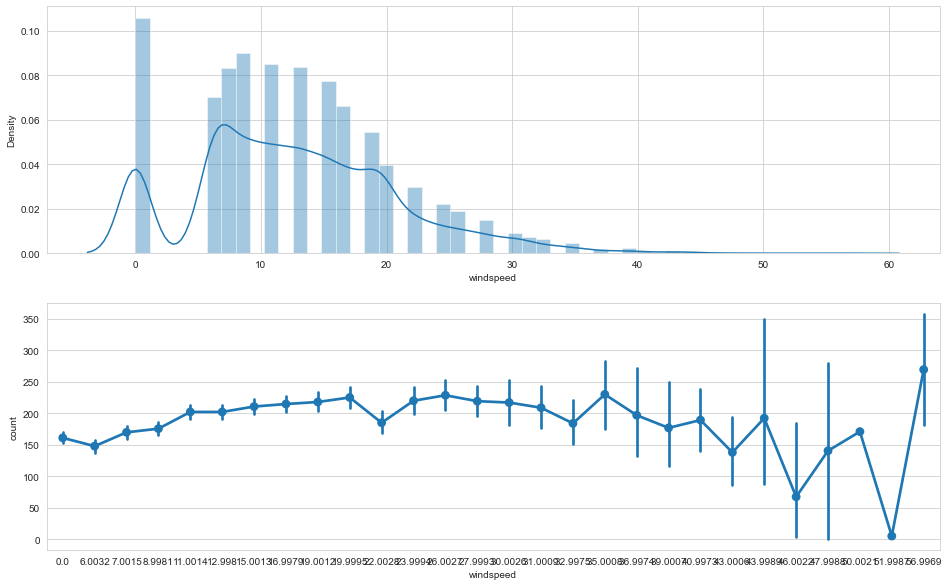

In [25]:
figure, ((ax1,ax2)) = plt.subplots(nrows=2, ncols=1)

figure.set_size_inches(16,10)

sns.distplot(train["windspeed"], ax=ax1)
sns.pointplot(data = train, x="windspeed", y="count", ax=ax2)

The chart shows that
- [figure1] Overall of windspeed's distribution by distplot.
- [figure2] Visualize the change in count of bike rental according to the windspeed by pointplot

 1. [figure1] chart looks like generally **Normal Distribution** but the values are not continuous and not steady. So, this data appear close to categorical rather tnah continuous data.
 2. Unusually the wind speed is often "0" value and has a high proportion.
 3. In addition, the higher the windspeed makes the less bicycles rented. But it seems to not highly reliable because of lack of data. However if the wind speed is low, the overall bicycle rental is low (windspeed data could be critical factor for ML)

C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='windspeed_point', ylabel='Density'>

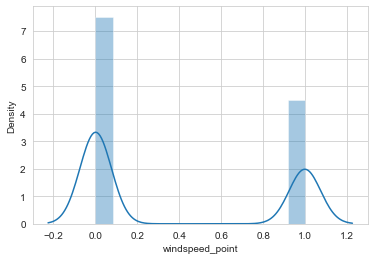

In [26]:
train["windspeed_int"] = train['windspeed'].astype('int')
train["windspeed_point"] = train["windspeed"] - train["windspeed_int"]

sns.distplot(train['windspeed_point'])

**Conclusion**

1. 이 풍속(windspeed) 데이터를 머신러닝 알고리즘에 집어넣으면 머신러닝 알고리즘의 풍속에 따른 자전거 대여량의 변화를 스스로 판단할 수 있을 것 같습니다. 더 정확히는, 풍속이 낮거나 높을수록 자전거를 덜 빌리고, 풍속이 적당할 때 자전거를 더 많이 빌린다는 사실을 알 수 있습니다.
1. 풍속(windspeed)이 0인 경우는, 실제로는 풍속이 0이 아니라 값이 비어있을(NaN) 가능성이 있습니다. 이 경우에는 풍속(windspeed) 데이터를 머신러닝 알고리즘에 그대로 집어넣을 경우, 실제로는 바람이 불었지만 머신러닝 알고리즘 입장에서는 바람이 불지 않았다고 간주할 수 있습니다. 이 문제를 해결해준다면 머신러닝 알고리즘의 성능을 크게 끌어올릴 수 있을 것 같습니다.
1. 또한 풍속(windspeed)의 소수점을 자세히 보시면, 0.001xx, 0.002xx, 0.003xx나, 0.999xx, 0.998xx, 0.997xx가 대부분입니다. 즉, 이 값은 실수형(float)이 아닌 정수형(int)이라고 간주할 수 있습니다. 알고리즘에 따라 다르겠지만, 풍속(windspeed) 데이터를 그대로 넣지 않고 반올림한 뒤 정수형(int) 데이터로 넣어주면 더 좋은 결과가 나올 수도 있습니다.

In [27]:
# dataframe, windspeed ==0
windspeed_0 = train[train["windspeed"] == 0]
# dataframe, windspeed !=0
windspeed_not0 = train[train["windspeed"] != 0]

windspeed_0_train = windspeed_0.drop(['datetime', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'year_month',
       'year_season', 'weather_encoded', 'windspeed_point', 'windspeed_int'], axis=1)

windspeed_not0_train = windspeed_not0.drop(['datetime', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'year_month',
       'year_season', 'weather_encoded', 'windspeed_point', 'windspeed_int'], axis=1)

windspeed_not0_label = windspeed_not0["windspeed"]

model_windspeed = RandomForestRegressor()
model_windspeed.fit(windspeed_not0_train, windspeed_not0_label)
windspeed_0_prediction = model_windspeed.predict(windspeed_0_train)
windspeed_0["windspeed"] = windspeed_0_prediction
windspeed_df = pd.concat([windspeed_0, windspeed_not0], axis=0)
windspeed_df["windspeed"].head()

<ipython-input-27-197fb2ff38ec>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windspeed_0["windspeed"] = windspeed_0_prediction


0    12.481028
1    14.030314
2    14.030314
3     7.664261
4     7.664261
Name: windspeed, dtype: float64

In [28]:
train["windspeed_encoded"] = windspeed_df["windspeed"]
train.loc[train["windspeed"] == 0, ["windspeed", "windspeed_encoded"]].head()

,windspeed,windspeed_encoded
0,0.0,12.481028
1,0.0,14.030314
2,0.0,14.030314
3,0.0,7.664261
4,0.0,7.664261


6.0032


C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='windspeed_encoded', ylabel='Density'>

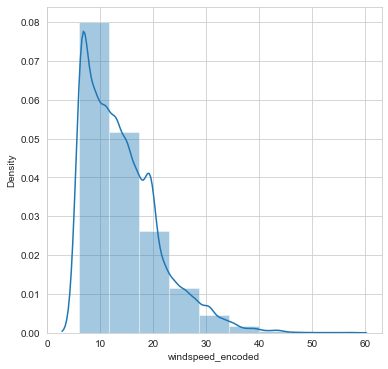

In [29]:
plt.figure(figsize=(6,6))
print(train["windspeed_encoded"].min())
sns.distplot(train['windspeed_encoded'],bins=np.linspace(train['windspeed_encoded'].min(),train['windspeed_encoded'].max(),10))

<AxesSubplot:>

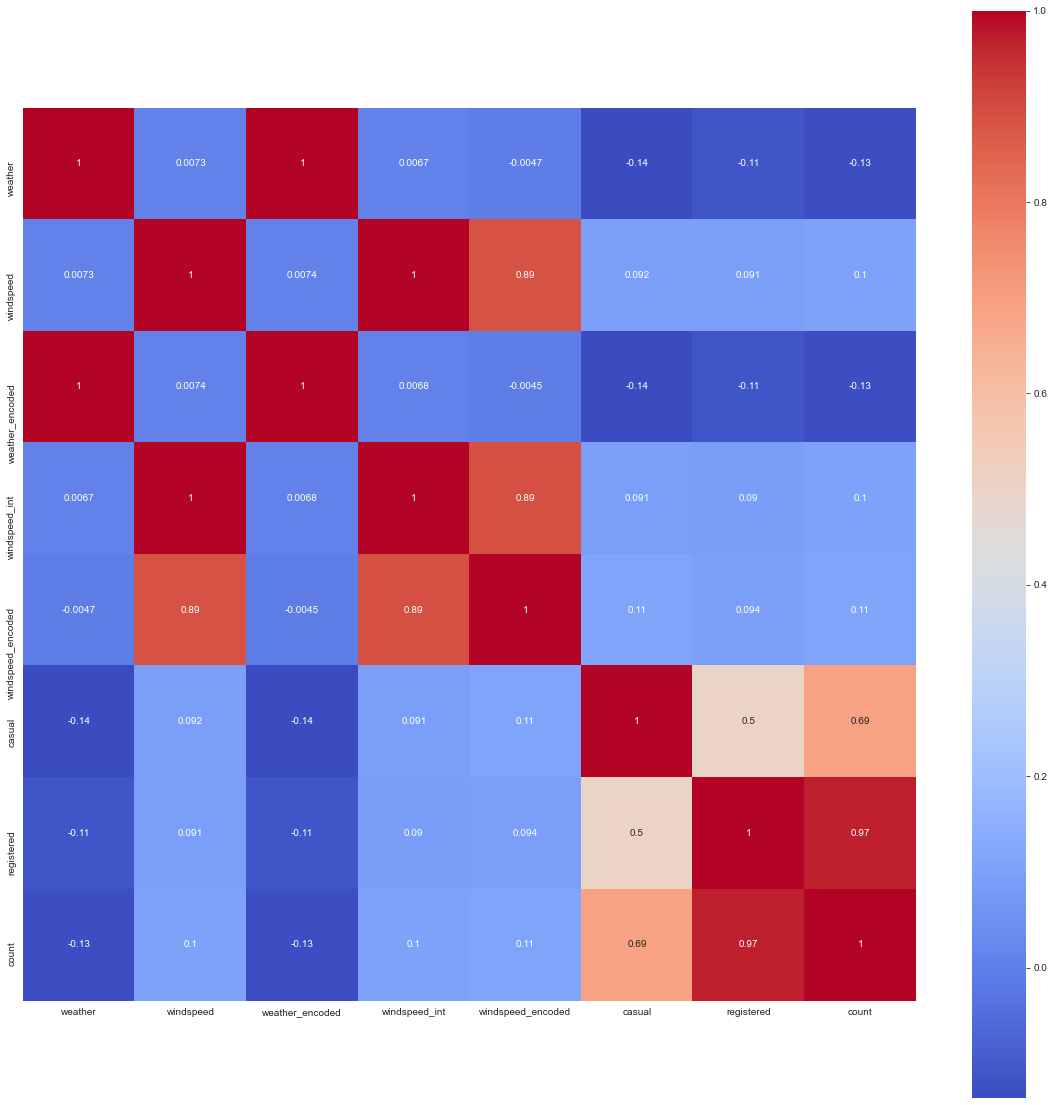

In [30]:
cols = ['weather', 'windspeed', 'weather_encoded', 'windspeed_int', 'windspeed_encoded',
       'casual', 'registered', 'count']
corr = train[cols].corr()
mask = np.array(corr)

plt.figure(figsize=(20,20))
sns.heatmap(corr, vmax=1, square=True, annot=True, cmap="coolwarm")

windspeed -> weather_encoded : correlation 0.1 ↑

#### 4) temp

<AxesSubplot:xlabel='temp_int', ylabel='atemp_int'>

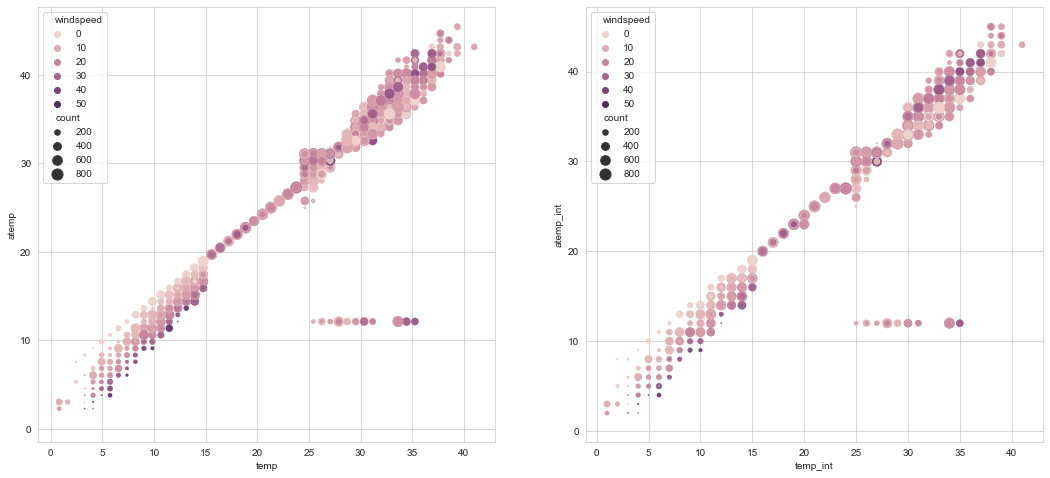

In [31]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,8)

train["temp_int"] = train['temp'].round()
train["atemp_int"] = train['atemp'].round()

sns.scatterplot(data=train, x="temp", y="atemp", hue="windspeed", size="count", sizes=(0, 150), ax=ax1)
sns.scatterplot(data=train, x="temp_int", y="atemp_int", hue="windspeed", size="count", sizes=(0, 150), ax=ax2)

In [32]:
function = np.polyfit(train["temp_int"], train["atemp_int"], 1)
function[:]

array([1.07142963, 1.99659939])

 * "temp_int"와 "atemp_int"의 관계식
 
 $$ atemp(int) = function[0] * temp(int) + function[1] $$

In [33]:
train["temp_atemp"] = train['temp_int'] - train['atemp_int']
cols = ["temp_int", "atemp_int", "temp_atemp"]

train[cols].head()

,temp_int,atemp_int,temp_atemp
0,10.0,14.0,-4.0
1,9.0,14.0,-5.0
2,9.0,14.0,-5.0
3,10.0,14.0,-4.0
4,10.0,14.0,-4.0


In [34]:
train["temp_atemp"].value_counts()

-4.0     5106
-3.0     2097
-2.0     1415
-5.0     1049
-1.0      509
-6.0      405
 0.0      219
 1.0       32
-7.0       21
 22.0       5
-8.0        5
 14.0       5
 2.0        4
 16.0       3
 15.0       3
 18.0       3
 23.0       2
 17.0       1
 13.0       1
 19.0       1
Name: temp_atemp, dtype: int64

Theis few data in condition ["temp_atemp" > 0] and ["temp_atemp" < -6].

<AxesSubplot:xlabel='temp_final', ylabel='count'>

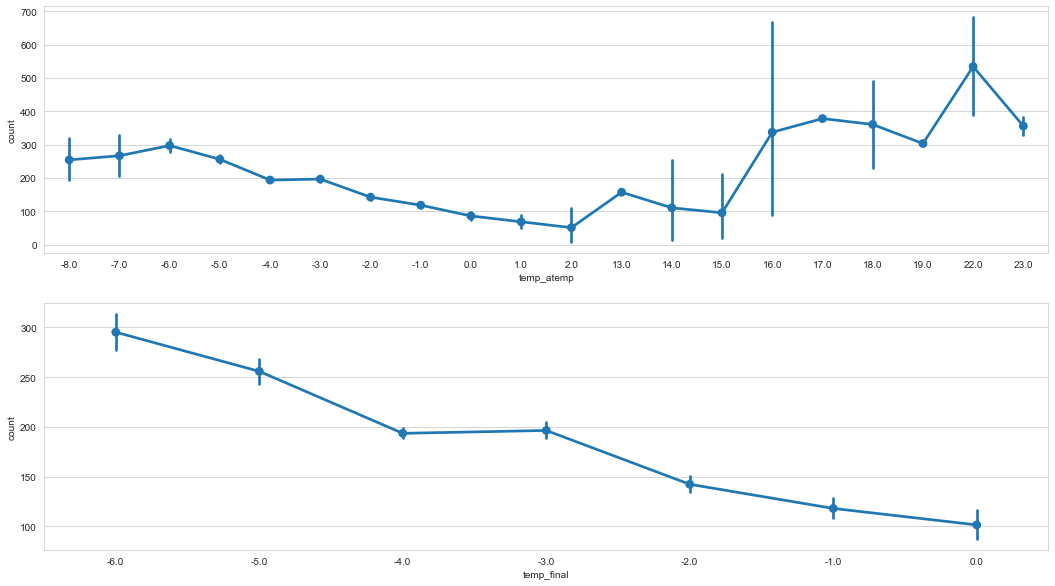

In [35]:
train["temp_final"] = train["temp_atemp"].copy()
train.loc[train['temp_atemp'] > 0, "temp_final"] = 0
train.loc[train["temp_atemp"] < -6, "temp_final"] = -6

figure, ((ax1,ax2)) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18,10)

sns.pointplot(data=train, x="temp_atemp", y="count", ax=ax1)
sns.pointplot(data=train, x="temp_final", y="count", ax=ax2)

In [36]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'year_month',
       'year_season', 'year_season_20111', 'year_season_20112',
       'year_season_20113', 'year_season_20114', 'year_season_20121',
       'year_season_20122', 'year_season_20123', 'year_season_20124',
       'weather_encoded', 'windspeed_int', 'windspeed_point',
       'windspeed_encoded', 'temp_int', 'atemp_int', 'temp_atemp',
       'temp_final'],
      dtype='object')

In [37]:
c1 = train['atemp'] < 20
c2 = train['temp'] > 20

train['atemp_encoded'] = train['atemp'].copy()
train.loc[c1 & c2, 'atemp_encoded'] = train['temp'] + 2
train.loc[c1 & c2, ['temp','atemp', 'atemp_encoded']].head()

,temp,atemp,atemp_encoded
8991,27.88,12.12,29.88
8992,27.06,12.12,29.06
8993,27.06,12.12,29.06
8994,26.24,12.12,28.24
8995,26.24,12.12,28.24


<AxesSubplot:xlabel='temp', ylabel='atemp_encoded'>

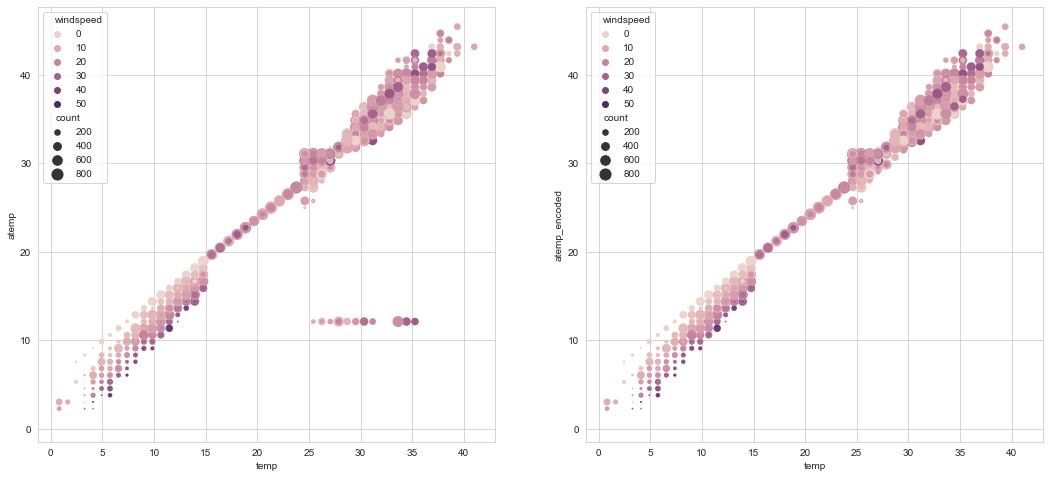

In [38]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,8)

sns.scatterplot(data=train, x="temp", y="atemp", hue="windspeed", size="count", sizes=(0, 150), ax=ax1)
sns.scatterplot(data=train, x="temp", y="atemp_encoded", hue="windspeed", size="count", sizes=(0, 150), ax=ax2)

### Q4-2) 이 시각화로 발견할 수 있는 사실은 어떤 게 있을까요? 그리고 앞서 우리의 예상과 어떤 차이가 있나요?

1. 앞서 예상과 마찬가지로, 온도(```temp```)와 체감온도(```atemp```)는 연속형(continuous)인 데이터이며, 서로 상관관계가 높다는 사실을 알 수 있습니다.
1. 또한 온도(```temp```)나 체감온도(```atemp```)가 낮을수록 자전거를 덜 빌리고, 높을수록 자전거를 많이 빌린다는 사실을 알 수 있습니다.
1. 하지만 가끔 온도(```temp```)에 비해서 체감온도(```atemp```)가 상대적으로 높거나 낮은 경우가 있는데, 특히나 체감온도(```atemp```)가 온도(```temp```)보다 높을 경우 자전거를 더 많이 빌린다는 현상을 알 수 있습니다.

### Q4-3) 이 사실을 통해 어떻게 예측 모델을 개선할 수 있을까요? 최소 3가지 아이디어를 내보세요.
1. 온도(```temp```) 컬럼이 자전거 대여량을 예측하는데 도움이 된다는 사실을 알 수 있습니다. 이 컬럼을 머신러닝 알고리즘에 넣어주면 머신러닝 알고리즘이 온도에 따른 자전거 대여량의 변화량을 예측하면서 성능이 올라갈 것으로 보입니다.

1. 또한 비슷하게 체감온도(```atemp```)도 자전거 대여량을 예측하는데 도움이 됩니다. 다만 온도(```temp```)와 체감온도(```atemp```)는 서로 비슷한 성향을 가지기 때문에, 두 컬럼 모두를 넣는건 둘 중 하나만 넣는 것에 비해 머신러닝 알고리즘의 성능을 향상시키는데 큰 도움을 주지는 못할 것입니다.

1. 또한 온도(```temp```)와 체감온도(```atemp```)의 차이가 자전거 대여량을 예측하는데 도움이 된다는 새로운 사실을 알 수 있었습니다. 이 정보를 머신러닝 알고리즘에 넣어주면 머신러닝의 성능 향상을 꾀할 수 있을 것으로 보입니다.

#### 5) datetime-dayofweek

이번에 분석할 데이터는 요일을 나타내는 데이터, 일명 ```datetime-dayofweek```입니다. 이 데이터는 현재 feature로 가지고 있지만, 날짜와 시간을 나타내는 ```datetime``` 컬럼에서 추출할 수 있습니다. (ex: ```train["datetime"].dt.day_name()```) 앞서 분석과 마찬가지로, 날짜 컬럼도 탐험적 데이터 분석을 통해 분석해보겠습니다.

In [39]:
train["weekday"] = train["datetime"].dt.day_name()
train["weekday_int"] = train["datetime"].dt.dayofweek
test["weekday"] = test["datetime"].dt.day_name()
test["weekday_int"] = test["datetime"].dt.dayofweek

In [40]:
train[["weekday", "weekday_int"]].head(2)

,weekday,weekday_int
0,Saturday,5
1,Saturday,5


In [41]:
train["weekday"].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

<AxesSubplot:xlabel='hour', ylabel='count'>

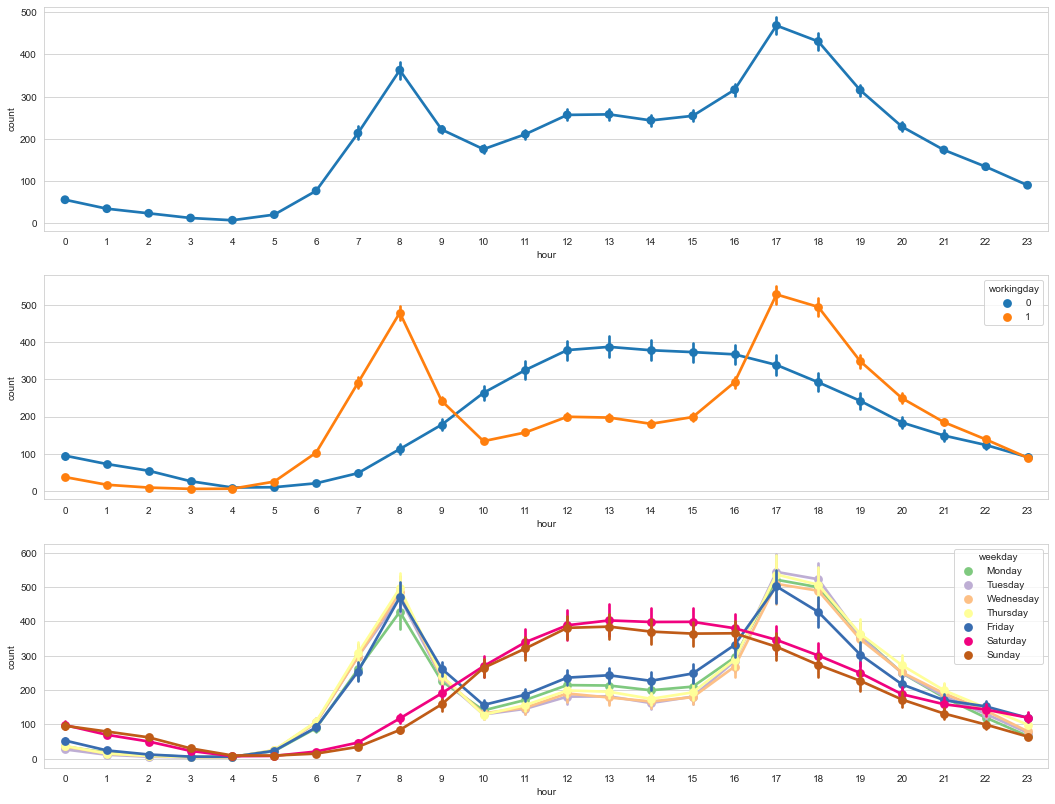

In [42]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,14)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']

sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", ax=ax2, hue="workingday")
sns.pointplot(data=train, x="hour", y="count", ax=ax3, hue="weekday", hue_order=weekday_order, palette='Accent')

### Q5-2) 이 시각화로 발견할 수 있는 사실은 어떤 게 있을까요? 그리고 앞서 우리의 예상과 어떤 차이가 있나요?

확실히 주중/주말을 나누는 ```workingday``` 컬럼에 비해, 구체적인 요일을 나타내는 ```datetime-dayofweek``` 컬럼이 더 디테일한 자전거 변화량을 나타낸다는 사실을 알 수 있습니다. 구체적으로는

1. 같은 주말이라고 하더라도 일요일이 토요일보다 자전거 대여량이 낮습니다. 이는 추측컨데 일요일은 다음 날이 근무일(월요일)이므로, 레크레이션이나 액티비티를 즐기고 싶다면 토요일에 즐기고 싶다는 사실이 드러난게 아닐까 생각합니다.
1. 비슷한 관점에서, 같은 주중이라도 금요일이 퇴근하는 시간대(18시 ~ 20시)에 자전거 대여량이 다른 주중에 비해 낮습니다. 이는 추측컨데 다음 날이 휴일(토요일)이므로, 금요일 밤을 즐기기 위해 차를 몰고 왔거나, 음주 후 차량이나 자전거를 이용할 수 없어서 다른 대중교통(버스, 지하철, 택시 등)을 이용한게 아닐까 생각합니다.
1. 또한 금요일은 같은 주중이라고 하더라도 오후 시간대(10시 ~ 16시)에 자전거 대여량이 높습니다. 그리고 그 다음 높은 주중이 월요일입니다. 이는 금요일과 월요일은 주중임에도 불구하고 주말과 끼여있는 요일이기 때문에, 주말의 성향을 어느정도 타는게 아닐까 생각합니다.


In [43]:
train["weekend"] = 0

c1 = train['holiday'] == 0
c2 = train['workingday'] == 0

train.loc[c1 & c2, "weekend"] = 1
train[["holiday", 'workingday', "weekend"]].head()

,holiday,workingday,weekend
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [44]:
print(train["weekend"].value_counts())
print(train["holiday"].value_counts())
print(train["workingday"].value_counts())

train.shape[0] == train["weekend"].value_counts()[1] + train["holiday"].value_counts()[1] + train["workingday"].value_counts()[1]

0    7723
1    3163
Name: weekend, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64


True

<AxesSubplot:xlabel='hour', ylabel='count'>

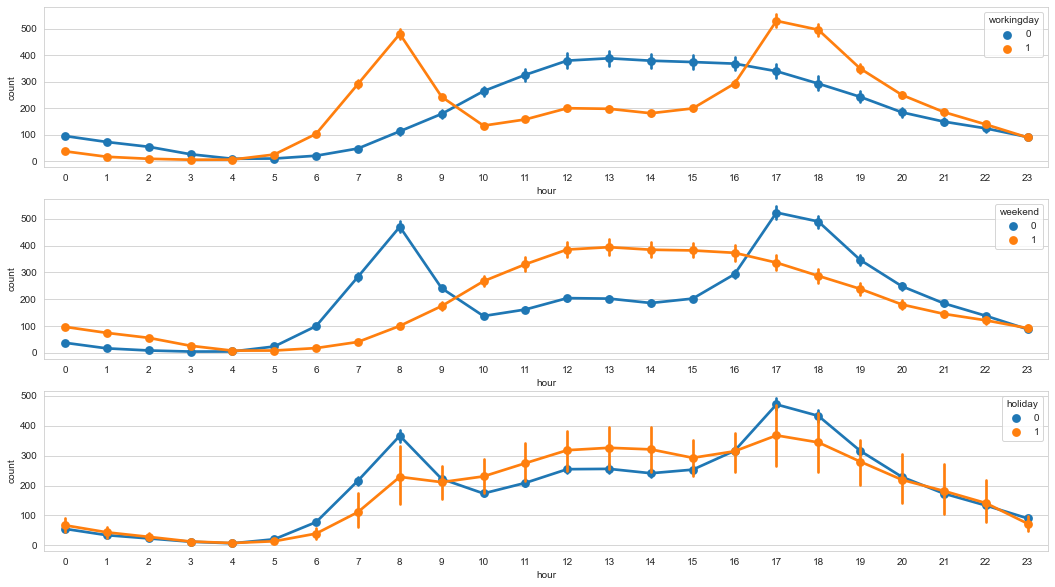

In [45]:
figure, (ax1,ax2, ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,10)

# weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="weekend", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="holiday", ax=ax3)

### Q5-3) 이 사실을 통해 어떻게 예측 모델을 개선할 수 있을까요? 최소 3가지 아이디어를 내보세요.

1. 일단 요일(```datetime-dayofweek```) 컬럼을 머신러닝 모델에 집어넣으면, 머신러닝 모델이 요일에 따른 자전거 변화량의 차이를 이해하기 시작하면서 성능이 올라갈 것으로 예상합니다.
2. 구체적으로는 같은 주말이라고 하더라도 토요일과 일요일의 차이, 같은 주중이라고 하더라도 수요일과 월요일의 차이를 이해하기 시작할 것입니다. 이런 점에서 근무일(```workingday```)컬럼만 넣는 것 보다 요일(```datetime-dayofweek```) 컬럼을 넣는 것이 더 좋은 성능을 낼 것입니다.
3. 그리고 이 데이터는 연속적(continuous) 데이터가 아닌 범주형(categorical) 데이터입니다. 그 의미는, 이 데이터를 그대로 넣지 않고 타이타닉 경진대회의 선착장(```Embarked```) 컬럼과 같이 One Hot Encoding을 해서 넣어주는게 머신러닝 알고리즘이 이해하기 쉽고, 더 좋은 성능을 낼 것으로 예상합니다.

#### 6) Casual & Registered

<br>

이번에 분석할 데이터는 비회원과 회원을 나타내는 데이터, ```casual```과 ```registered``` 컬럼입니다. 이 컬럼을 자전거 대여량을 나타내는 ```count``` 컬럼과 거의 유사합니다. (실제로 ```casual``` 컬럼값과 ```registered``` 컬럼값을 더하면 ```count``` 컬럼값이 나옵니다)

하지만 아쉽게도 이 컬럼은 train 데이터에는 있지만 test 데이터에는 없습니다. 그러므로 이 데이터를 머신러닝 모델의 feature로 쓰는건 불가능합니다. 그렇다고 label로 쓰기에는, 우리가 맞춰야 하는 정답(=label)은 ```count``` 컬럼이죠. 하지만 그럼에도 불구하고, 이 두 개의 컬럼은 ```count``` 컬럼과 밀접한 연관이 있기 때문에, 잘 분석하고 이용한다면 머신러닝 모델의 성능을 크게 끌어올릴 수 있을 것 같습니다.

Casual과 Registered를 각각의 label로 예측하여 분석하면 더욱 좋은 결과를 예상할 수 있다.

### Q6-1) ```casual```과 ```registered```  컬럼을 시각화 하기 전에 어떤 그림이 나올 것으로 예상하시나요?

주의: 이 내용은 반드시 시각화를 하기 전에 작성하셔야 합니다. 그래야 시각화 결과와 본인의 아이디어를 비교해서 차이를 발견할 수 있습니다.

1. 일단 두 개의 컬럼은 자전거 대여량을 나타내는 ```count``` 컬럼과 유사하므로, 시각화를 하면 거의 유사한 패턴이 나올 것으로 생각합니다.
1. 하지만 두 회원간의 자전거 대여 성향이 다르기 때문에, 자전거를 대여하는 시기나 타이밍에 있어서 미묘하게 차이가 나지 않을까 합니다.
1. 그리고 회원의 자전거 대여량에 해당하는 ```registered```에 비해, 비회원의 자전거 대여량에 해당하는 ```casual``` 컬럼이 더 패턴을 찾기 어려울 것입니다. (비회원이라는건 그만큼 비정기적으로 자전거를 대여하는 것이기 때문에) 이 점을 감안해서 분석하는게 좋을 것 같습니다.

위 예상과 실제 데이터가 일치하는지 시각화를 통해 분석해보도록 하겠습니다.

<AxesSubplot:xlabel='hour', ylabel='registered'>

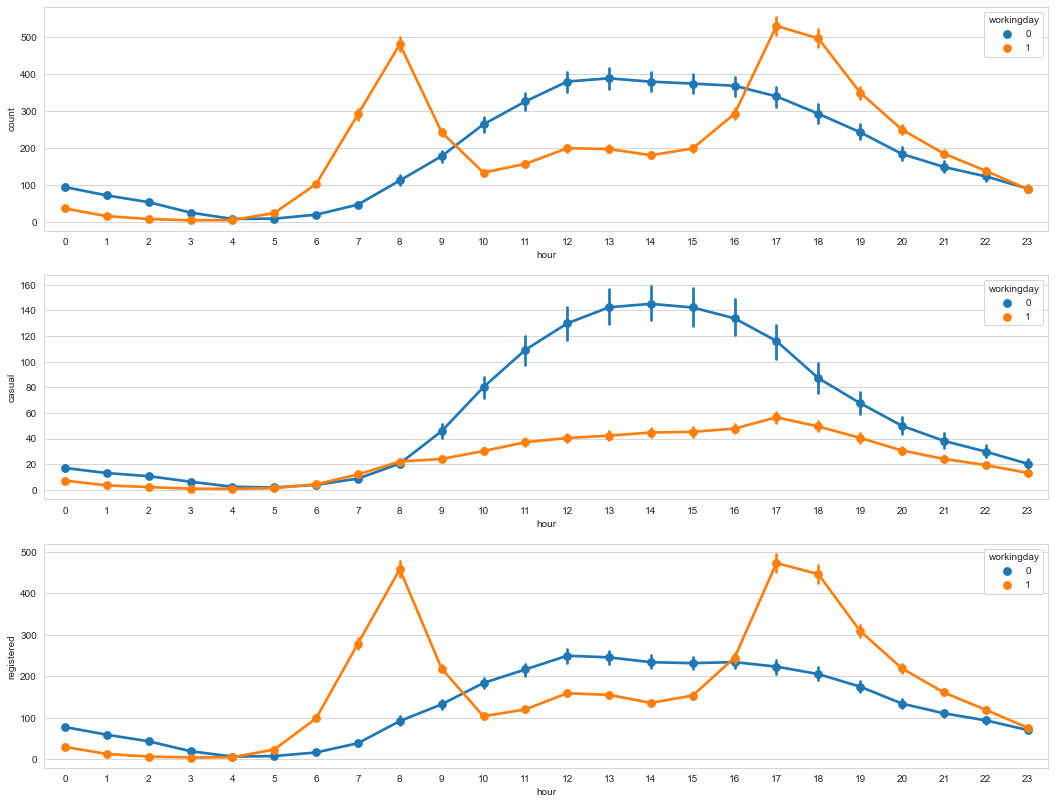

In [46]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,14)

sns.pointplot(data=train, x="hour", y="count", ax=ax1, hue="workingday")
sns.pointplot(data=train, x="hour", y="casual", ax=ax2, hue="workingday")
sns.pointplot(data=train, x="hour", y="registered", ax=ax3, hue="workingday")

<AxesSubplot:xlabel='hour', ylabel='registered'>

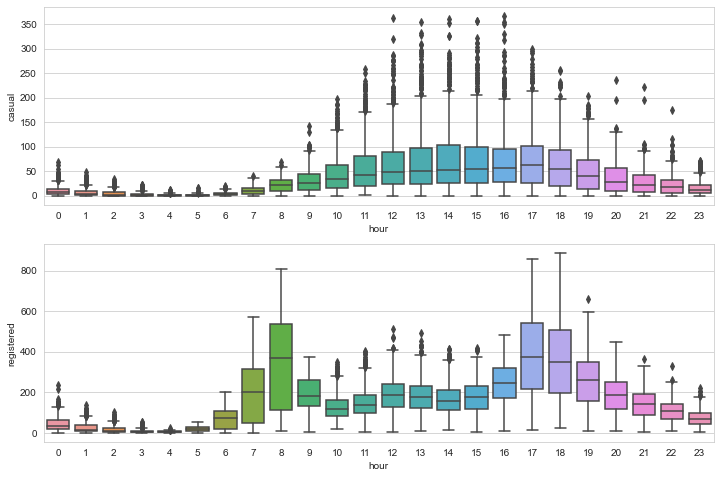

In [47]:
figure, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(12,8)

sns.boxplot(x='hour', y='casual', data=train, ax=ax1)
sns.boxplot(x='hour', y='registered', data=train, ax=ax2)

### Q6-2) 이 시각화로 발견할 수 있는 사실은 어떤 게 있을까요? 그리고 앞서 우리의 예상과 어떤 차이가 있나요?

1. 시간(```datetime-hour```)에 따른 자전거 대여량의 변화량을 비교해보니, 비회원과 회원의 차이가 극명하게 난다는 사실을 알 수 있습니다.
2. 구체적으로는, 회원(```registered```)은 주로 출퇴근할때 자전거를 빌리고, 비회원(```casual```)은 주로 주말에 놀 때 자전거를 빌린다는 사실을 알 수 있습니다.
3. 그리고 시각화의 세로축(y축)을 보면 비회원(```casual```)보다는 회원(```registered```)이 자전거를 더 많이 빌린다는 사실을 알 수 있습니다.

### Q6-3) 이 사실을 통해 어떻게 예측 모델을 개선할 수 있을까요? 최소 3가지 아이디어를 내보세요.

1. 일단 아쉽게도, 비회원(```casual```)과 회원(```registered```) 정보는 test 데이터에 넣을 수 없기 때문에 feature로 활용할 수 없습니다.
2. 하지만 다른 방식을 통해서 유사하게 이 데이터를 쓸 수 있을 것 같습니다. 가령 머신러닝 모델로 자전거 대여량을 나타내는(```count```) 컬럼을 예측하는게 아닌, 비회원(```casual```)과 회원(```registered```) 컬럼을 각각 label로 간주하고 예측한 뒤 이를 더하는 것도 방법입니다.
3. 내지는 비회원(```casual```) 컬럼의 값이 작고 패턴을 예측하기 어렵기 때문에, 비회원(```casual```), 회원(```registered```), 그리고 ```count``` 컬럼까지 총 3개를 동시에 예측해서 이를 섞어쓰는 것도 가능합니다.

## Train

이제 분석을 통해 발견한 인사이트를 활용해보겠습니다.

이전 경진대회와 마찬가지로, 이번에도 머신러닝 알고리즘을 사용하겠습니다. 이번에도 변함없이 [지도학습(Supervised Learning)](http://solarisailab.com/archives/1785) 알고리즘을 사용할 계획이기 때문에, 데이터를 Label(맞춰야 하는 정답)과 Feature(Label을 맞추는데 도움이 되는 값들)로 나눌 필요가 있습니다.

이번 경진대회에서는 다음의 컬럼들을 Feature와 Label로 활용할 것입니다.

  * **Feature**: 1) 계절(```season```), 2) 공휴일(```holiday```), 3) 근무일(```workingday```), 4) 날씨(```weather```), 5) 온도(```temp```), 6) 체감 온도(```atemp```), 7) 습도(```humidity```), 8) 풍속(```windspeed```), 9) 연(```datetime-year```), 10) 시(```datetime-hour```), 11) 요일(```datetime-dayofweek(int)```) 입니다.
  
  * **Label**: 자전거 대여량(```count```)을 사용합니다.
  
이를 통해 train 데이터와 test 데이터를 다음의 세 가지 형태의 값으로 나눌 것입니다.

  * **X_train**: train 데이터의 feature 입니다. 줄여서 X_train이라고 부릅니다.
  * **X_test**: test 데이터의 feature 입니다. 마찬가지로 줄여서 X_test라고 부릅니다.
  * **y_train**: train 데이터의 label 입니다. 마찬가지로 줄여서 y_train이라고 부릅니다.

C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='count', ylabel='Density'>

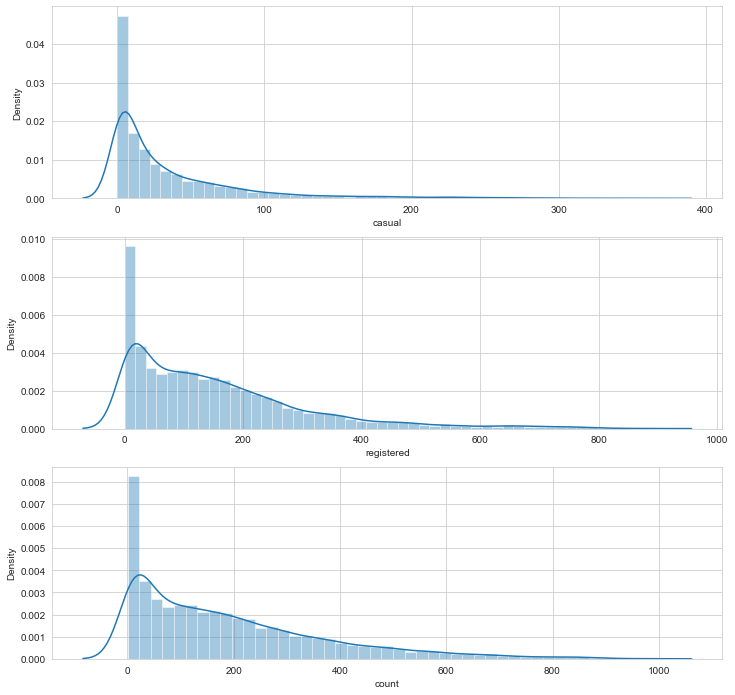

In [48]:
figure, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(12,12)

sns.distplot(train["casual"], ax=ax1)
sns.distplot(train["registered"], ax=ax2)
sns.distplot(train["count"], ax=ax3)

In [49]:
y_train_casual = train["casual"]
y_train_registered = train["registered"]
y_train_count = train["count"]

y_train_casual_log = np.log(y_train_casual + 1)
y_train_registered_log = np.log(y_train_registered + 1)
y_train_count_log = np.log(y_train_count + 1)

C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rhqdn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='count', ylabel='Density'>

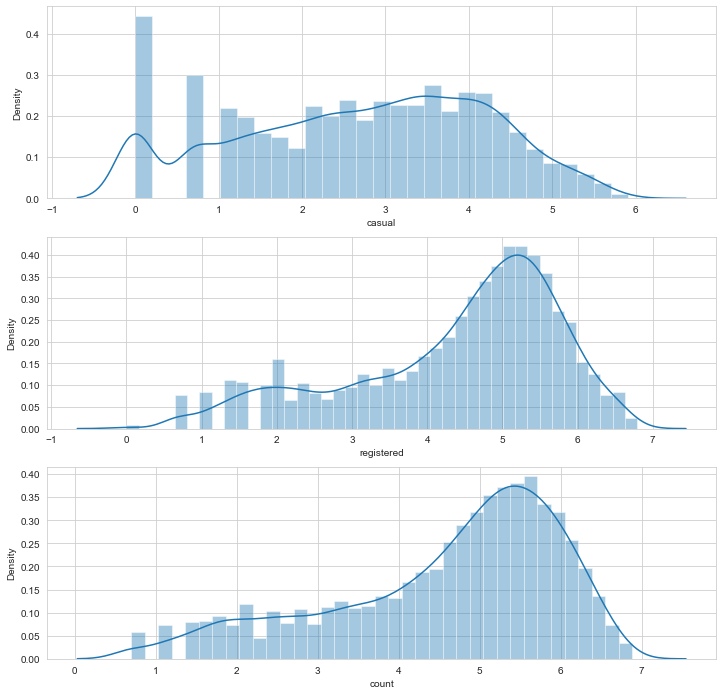

In [50]:
figure, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(12,12)

sns.distplot(y_train_casual_log, ax=ax1)
sns.distplot(y_train_registered_log, ax=ax2)
sns.distplot(y_train_count_log, ax=ax3)

Why we do **Log transformation** (Natural Logarithm)?

1. Bike Sharing Demand take the **RMSLE** method to determine how well result fits (Special case).
2. Machine Learing algorithm usually shows good performance when train data is nomarlized.


### Selection feature for optimizing ML perfomance (Statistical Hypothesis Test)

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=37,
                             n_estimators=10)

model

RandomForestRegressor(n_estimators=10, random_state=37)

In [52]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

feature_dict = {# Original
                "feature1" : ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 
                              'humidity', 'windspeed', 'year', 'hour', 'weekday_int'],

                # + windspeed_encoded, year_season (One Hot Encoding) 
                # - year, season
                "feature2" : ['holiday', 'workingday', 'weather', 'temp', 'atemp', 
                              'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 
                              'year_season_20112','year_season_20113', 'year_season_20114', 'year_season_20121',
                              'year_season_20122', 'year_season_20123', 'year_season_20124'],
                
                # + windspeed_encoded, year_season (One Hot Encoding) 
                # - year, season
                # temp, atemp → temp, atemp_encoded    
                "feature3" : ['holiday', 'workingday', 'weather', 'temp', 'atemp_encoded', 
                              'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 
                              'year_season_20112','year_season_20113', 'year_season_20114', 'year_season_20121',
                              'year_season_20122', 'year_season_20123', 'year_season_20124'],
    
                # + windspeed_encoded, year_season (One Hot Encoding) 
                # - year, season
                # temp, atemp → atemp
                "feature4" : ['holiday', 'workingday', 'weather', 'atemp', 
                              'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 
                              'year_season_20112','year_season_20113', 'year_season_20114', 'year_season_20121',
                              'year_season_20122', 'year_season_20123', 'year_season_20124'],
    
                # + windspeed_encoded, year_season (One Hot Encoding) 
                # - year, season
                #  temp, atemp → atemp
                # 'holiday', 'workingday', 'weekend' (One Hot Encoding)
                "feature5" : ['holiday', 'workingday', 'weather', 'atemp', 
                              'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 
                              'year_season_20112','year_season_20113', 'year_season_20114', 'year_season_20121',
                              'year_season_20122', 'year_season_20123', 'year_season_20124', 'weekend'],
    
                # + windspeed_encoded, year_season (One Hot Encoding) 
                # - year, season
                # temp, atemp → atemp_encoded
                # 'holiday', 'workingday', 'weekend' (One Hot Encoding)    
                "feature6" : ['holiday', 'workingday', 'weather', 'atemp_encoded', 
                              'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 
                              'year_season_20112','year_season_20113', 'year_season_20114', 'year_season_20121',
                              'year_season_20122', 'year_season_20123', 'year_season_20124', 'weekend'],
                # + windspeed_encoded, year_season (One Hot Encoding) 
                # - year, season
                # temp, atemp → temp
                # 'holiday', 'workingday', 'weekend' (One Hot Encoding)    
                 "feature7" : ['holiday', 'workingday', 'weather', 'temp', 
                              'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 
                              'year_season_20112','year_season_20113', 'year_season_20114', 'year_season_20121',
                              'year_season_20122', 'year_season_20123', 'year_season_20124', 'weekend']
}

features = list(feature_dict.values())

result = []

for feature in features:
    x_train = train[feature]
    
    # Cross Validation
      # Log Transform
    y_predict_casual_log = cross_val_predict(model, x_train, y_train_casual_log, cv = 20)
    y_predict_registered_log = cross_val_predict(model, x_train, y_train_registered_log, cv = 20)
    y_predict_count_log = cross_val_predict(model, x_train, y_train_count_log, cv = 20)
      # Exponential Transform
    y_predict_casual = np.exp(y_predict_casual_log) - 1
    y_predict_registered = np.exp(y_predict_registered_log) - 1
    y_predict_count = np.exp(y_predict_registered_log) - 1
      # Geometric mean (y_predict : Final Results)
    y_predict = np.sqrt((y_predict_casual+y_predict_registered)*y_predict_count)
    
    score = mean_squared_log_error(y_train_count, y_predict)
    score = np.sqrt(score)
    
    feature_num = features.index(feature) + 1
    
    result_dic = {
        'feature' : feature,
        'score' : score,
        'feature_num' : feature_num
    }
    
    result.append(result_dic)
    
    print(f"feature {feature_num} \nfeature_list : {feature} \n =====> score = {score:.5f} \n")

feature 1 
feature_list : ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'hour', 'weekday_int'] 
 =====> score = 0.38769 

feature 2 
feature_list : ['holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 'year_season_20112', 'year_season_20113', 'year_season_20114', 'year_season_20121', 'year_season_20122', 'year_season_20123', 'year_season_20124'] 
 =====> score = 0.38264 

feature 3 
feature_list : ['holiday', 'workingday', 'weather', 'temp', 'atemp_encoded', 'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 'year_season_20112', 'year_season_20113', 'year_season_20114', 'year_season_20121', 'year_season_20122', 'year_season_20123', 'year_season_20124'] 
 =====> score = 0.38171 

feature 4 
feature_list : ['holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 'year_season_20111', 'year_se

We can konw that "feature5" is the best feature for ML performance by Statistical Hypothesis Test.

<br>

feature5 : ['holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed_encoded', 'hour', 'weekday_int', 
            'year_season_20111', 'year_season_20112','year_season_20113', 'year_season_20114', 'year_season_20121',
            'year_season_20122', 'year_season_20123', 'year_season_20124', 'weekend']

### Feature Engineering for test.csv

In [53]:
feature = ['holiday', 'workingday', 'weather', 'atemp_encoded', 'humidity', 'windspeed_encoded', 'hour', 'weekday_int',
           'year_season_20111', 'year_season_20112', 'year_season_20113', 'year_season_20114', 'year_season_20121', 
           'year_season_20122', 'year_season_20123', 'year_season_20124', 'weekend']

#### windspeed_encoded

In [54]:
# dataframe, windspeed ==0
windspeed_0 = test[test["windspeed"] == 0]
# dataframe, windspeed !=0
windspeed_not0 = test[test["windspeed"] != 0]

windspeed_0_test = windspeed_0.drop(['datetime', 'windspeed', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'weekday', 'weekday_int'], axis=1)

windspeed_not0_test = windspeed_not0.drop(['datetime', 'windspeed', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'weekday', 'weekday_int'], axis=1)

windspeed_not0_label = windspeed_not0["windspeed"]

model_windspeed = RandomForestRegressor()
model_windspeed.fit(windspeed_not0_test, windspeed_not0_label)
windspeed_0_prediction = model_windspeed.predict(windspeed_0_test)
windspeed_0["windspeed"] = windspeed_0_prediction
windspeed_df = pd.concat([windspeed_0, windspeed_not0], axis=0)
windspeed_df["windspeed"].head()

<ipython-input-54-314ce6d80c30>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windspeed_0["windspeed"] = windspeed_0_prediction


1      8.912470
2      8.912470
12     6.888396
60     9.741807
62    17.227247
Name: windspeed, dtype: float64

In [55]:
test["windspeed_encoded"] = windspeed_df["windspeed"]
test.loc[test["windspeed"] == 0, ["windspeed", "windspeed_encoded"]].head()

,windspeed,windspeed_encoded
1,0.0,8.912470
2,0.0,8.912470
12,0.0,6.888396
60,0.0,9.741807
62,0.0,17.227247


#### year_season (One Hot Encoding)

In [56]:
test["year_season"] = test["year"].astype("str") + test["season"].astype("str")
test[["year", "season", "year_season"]].head()

,year,season,year_season
0,2011,1,20111
1,2011,1,20111
2,2011,1,20111
3,2011,1,20111
4,2011,1,20111


In [57]:
dummies = pd.get_dummies(test['year_season'], prefix='year_season')
dummies
test = pd.concat([test, dummies], axis=1)

In [58]:
cols = ['year_season', 'year_season_20111', 'year_season_20112', 'year_season_20113',
       'year_season_20114', 'year_season_20121', 'year_season_20122',
       'year_season_20123', 'year_season_20124']
test[cols].head()

,year_season,year_season_20111,year_season_20112,year_season_20113,year_season_20114,year_season_20121,year_season_20122,year_season_20123,year_season_20124
0,20111,1,0,0,0,0,0,0,0
1,20111,1,0,0,0,0,0,0,0
2,20111,1,0,0,0,0,0,0,0
3,20111,1,0,0,0,0,0,0,0
4,20111,1,0,0,0,0,0,0,0


#### weekend (One Hot Encoding) - "holiday", "workingday"

In [59]:
test["weekend"] = 0

c1 = test['holiday'] == 0
c2 = test['workingday'] == 0

test.loc[c1 & c2, "weekend"] = 1
test[["holiday", 'workingday', "weekend"]].head()

,holiday,workingday,weekend
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


#### atemp_encoded

<AxesSubplot:xlabel='temp', ylabel='atemp'>

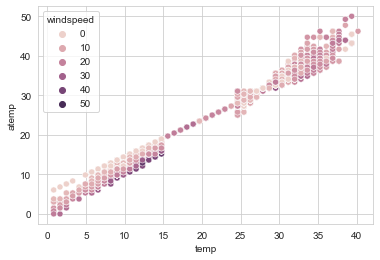

In [60]:
sns.scatterplot(data=test, x="temp", y="atemp", hue="windspeed", sizes=(0, 150))

In [61]:
c1 = test['atemp'] < 20
c2 = test['temp'] > 20

test['atemp_encoded'] = test['atemp'].copy()

### Random Forest
X_train, X_test, y_train 데이터를 만들었으면, 이제 이 데이터를 활용하여 머신러닝 알고리즘을 학습시켜 보겠습니다.

이번에 사용할 알고리즘은 랜덤 포레스트(Random Forest)입니다. 랜덤 포레스트는 의사결정나무(Decision Tree)의 업그레이드 버전이라고 볼 수 있는데, 대부분의 경우 의사결정나무보다 더 좋은 성능을 보장합니다. 알고리즘의 동작 원리는 다음과 같습니다.

먼저 전체 데이터가 아니라, 데이터의 일부분을 랜덤하게 가져옵니다. 이를 랜덤 샘플링, 또는 베깅(bootstrap aggregating)이라고 합니다. 이렇게 랜덤 샘플링한 데이터로 의사결정나무(Decision Tree)를 하나 만듭니다.
1번의 방식을 사용하면 이론적으로 무제한의 다양한 트리를 만들 수 있습니다. 이 트리를 지정한 갯수만큼 생성합니다.
생성한 트리끼리 투표를 합니다. 가령 타이타닉 승객 데이터를 제공했을 때, 1,000개의 트리 중 700개가 생존/300개가 사망했다고 하면 해당 승객은 생존했다고 가정합니다. 정 반대로 400개가 생존/600개가 사망했다고 하면 해당 승객은 사망했다고 가정합니다.
이러한 방식을 거치면 의사결정나무(Decision Tree)보다 더 강력한 알고리즘을 구현할 수 있습니다. (자세한 설명은 [다음의 링크](http://swalloow.tistory.com/92)를 참고 바랍니다)

그런 의미에서, 이번에도 파이썬의 머신러닝 패키지인 [scikit-learn](scikit-learn.org)에서 랜덤 포레스트([RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html))를 가져오겠습니다.

### Hyperparameter Tuning

랜덤 포레스트(Random Forest)를 사용하기로 마음 먹었으면, 이번에는 이 랜덤포레스트의 하이퍼패러미터를 튜닝해보겠습니다.

머신러닝 모델에는 다양한 옵션이 있으며, 이 옵션을 통해 모델의 성능을 끌어올릴 수 있습니다. 이 옵션들을 전문용어로 하이퍼패러미터(Hyperparameter)라고 부릅니다. 만일 적절한 하이퍼패러미터를 찾아서 모델에 적용할 수 있다면 모델의 성능을 한 층 더 끌어올릴 수 있습니다. 이를 **하이퍼패러미터 튜닝(Hyperparamter Tuning)**이라고 합니다.

어떻게 하면 가장 좋은 하이퍼패러미터를 찾을 수 있을까요? 답은 간단합니다. 이론상으로 존재 가능한 모든 하이퍼패러미터 범위에서 랜덤하게 찾아서 Cross Validation을 해보면 됩니다. 이 방식을 랜덤 서치(Random Search)라고 합니다.

<img src="http://cs231n.github.io/assets/nn3/gridsearchbad.jpeg" alt="Random Search for Hyper-Parameter Optimization" style="width: 360px;"/>

<p style="text-align: center;">
  <small>
    위 그림과 같이, Grid Search를 활용하면 가장 좋은 성능을 내는 하이퍼패러미터를 찾기 어렵습니다. 이런 경우는 Random Search를 사용합니다.
  </small>
</p>
<p style="text-align: center;">
  <small>
    (see <a href="http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf">Random Search for Hyper-Parameter Optimization</a>)
  </small>
</p>

하지만 랜덤 서치(Random Search)는 현실적으로 시간이 오래 걸리기 때문에, 랜덤 서치(Random Search)를 응용한 다른 하이퍼패러미터 튜닝 방식을 사용하겠습니다. 바로 **Coarse & Fine Search** 입니다.

Coarse & Fine Search는 크게 1) Coarse Search와 2) Fine Search로 동작합니다

먼저 **Coarse Search**에서는 Random Search를 하되, 이론상으로 존재 가능한 모든 하이퍼패러미터 범위를 집어넣습니다. 이렇게 Random Search를 하면 가장 좋은 하이퍼패러미터를 찾는 것은 어렵지만, **좋지 않은 하이퍼패러미터를 정렬해서 후순위로 놓을 수 있습니다.**

이를 통해 좋지 않은 하이퍼패러미터를 버린 뒤 다시 한 번 Random Search를 하는 것을 **Fine Search**라고 합니다.

#### Random Search(Coarse)

In [62]:
x_train = train[feature]
print(x_train.shape)
x_train.head()

(10886, 17)


,holiday,workingday,weather,atemp_encoded,humidity,windspeed_encoded,hour,weekday_int,year_season_20111,year_season_20112,year_season_20113,year_season_20114,year_season_20121,year_season_20122,year_season_20123,year_season_20124,weekend
0,0,0,1,14.395,81,12.481028,0,5,1,0,0,0,0,0,0,0,1
1,0,0,1,13.635,80,14.030314,1,5,1,0,0,0,0,0,0,0,1
2,0,0,1,13.635,80,14.030314,2,5,1,0,0,0,0,0,0,0,1
3,0,0,1,14.395,75,7.664261,3,5,1,0,0,0,0,0,0,0,1
4,0,0,1,14.395,75,7.664261,4,5,1,0,0,0,0,0,0,0,1


In [63]:
x_test = test[feature]
print(x_test.shape)
x_test.head()

(6493, 17)


,holiday,workingday,weather,atemp_encoded,humidity,windspeed_encoded,hour,weekday_int,year_season_20111,year_season_20112,year_season_20113,year_season_20114,year_season_20121,year_season_20122,year_season_20123,year_season_20124,weekend
0,0,1,1,11.365,56,26.00270,0,3,1,0,0,0,0,0,0,0,0
1,0,1,1,13.635,56,8.91247,1,3,1,0,0,0,0,0,0,0,0
2,0,1,1,13.635,56,8.91247,2,3,1,0,0,0,0,0,0,0,0
3,0,1,1,12.880,56,11.00140,3,3,1,0,0,0,0,0,0,0,0
4,0,1,1,12.880,56,11.00140,4,3,1,0,0,0,0,0,0,0,0


In [64]:
pd.concat([y_train_casual_log, y_train_registered_log, y_train_count_log], axis=1).head()

,casual,registered,count
0,1.386294,2.639057,2.833213
1,2.197225,3.496508,3.713572
2,1.791759,3.332205,3.496508
3,1.386294,2.397895,2.639057
4,0.000000,0.693147,0.693147


In [65]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error # RMSLE Method (Excepting for Only Root)

n_estimators = 300
# Generally the more n_estimators, the better performance.. but it's too slow for finding hyperparameters
# So, n_estimators set 300 at first. And after fixing hyperparameters, set the n_estimators more higher such as 1000.
num_epoch = 100
# Randomly repeats 100 searches.
coarse_hyperparameters_list = []
# Save hyperparameter results as a list 

for epoch in range(num_epoch):
    max_depth = np.random.randint(low = 2, high = 100) # Extract integer number randomly from 2 to 100
    max_features = np.random.uniform(low = 0.1, high = 1.0) # Extract float number randomly from 0.1 to 1
    model = RandomForestRegressor(n_estimators = n_estimators,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 n_jobs = -1,
                                 random_state = 37)
    # Cross Validation
      # Log Transform
    y_predict_casual_log = cross_val_predict(model, x_train, y_train_casual_log, cv = 20)
         # cv : Number of data to be split in Cross Vailidation
      # Exponential Transform
    y_predict_casual = np.exp(y_predict_casual_log) - 1
        
    score = mean_squared_log_error(y_train_casual, y_predict_casual)
    score = np.sqrt(score)
    
    hyperparameters = {
        'epoch' : epoch,
        'score' : score,
        'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'max_features' : max_features
    }
    coarse_hyperparameters_list.append(hyperparameters)
    
    print(f"{epoch:2} --- n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by = "score")
print(coarse_hyperparameters_list.shape)
coarse_hyperparameters_list.head(10)

 0 --- n_estimators = 300, max_depth = 10, max_features = 0.885846, Score = 0.56136
 1 --- n_estimators = 300, max_depth = 53, max_features = 0.614077, Score = 0.55571
 2 --- n_estimators = 300, max_depth = 73, max_features = 0.892878, Score = 0.55944
 3 --- n_estimators = 300, max_depth = 70, max_features = 0.276546, Score = 0.57581
 4 --- n_estimators = 300, max_depth = 97, max_features = 0.766972, Score = 0.55798
 5 --- n_estimators = 300, max_depth = 96, max_features = 0.809241, Score = 0.55798
 6 --- n_estimators = 300, max_depth = 75, max_features = 0.535195, Score = 0.55638
 7 --- n_estimators = 300, max_depth = 61, max_features = 0.236127, Score = 0.57581
 8 --- n_estimators = 300, max_depth = 52, max_features = 0.545710, Score = 0.55638
 9 --- n_estimators = 300, max_depth = 46, max_features = 0.342204, Score = 0.56632
10 --- n_estimators = 300, max_depth = 67, max_features = 0.437610, Score = 0.55660
11 --- n_estimators = 300, max_depth = 97, max_features = 0.507294, Score = 

98 --- n_estimators = 300, max_depth = 55, max_features = 0.214606, Score = 0.59636
99 --- n_estimators = 300, max_depth =  7, max_features = 0.619123, Score = 0.60629
(100, 5)


,epoch,score,n_estimators,max_depth,max_features
83,83,0.553807,300,13,0.667734
44,44,0.555361,300,26,0.592220
63,63,0.555414,300,31,0.629088
18,18,0.555415,300,18,0.580723
1,1,0.555706,300,53,0.614077
65,65,0.555706,300,87,0.589013
21,21,0.555715,300,13,0.478743
87,87,0.555787,300,15,0.798747
52,52,0.556303,300,28,0.426476
30,30,0.556338,300,31,0.412635


In [66]:
coarse_hyperparameters_list.to_csv("coarse_hyperparameters_result_casual.csv", index = False)

Set the **RandomForest** model

- n_estimators : Number of DecisionTree
- max_depth : 트리의 깊이입니다. 지정한 숫자만큼 트리가 깊게 가지를 뻗습니다.
- max_features : Feature Sampling입니다. 0.0 ~ 1.0 사이의 값을 넣으면, 트리를 생성할 때 전체 feature에서 지정한 비율만큼만 feature를 사용합니다.
- n_jobs : 병렬 처리 여부. -1 대입하면 컴퓨터의 모든 코어(듀얼, 쿼드코어)를 활용
- random_state : 랜덤포레스트의 결과가 랜덤하게 나오는 것을 고정하는 숫자 (공학용어인 Seed Number와 동일한 개념)

###  Random Search (Fine)

From Coarse Search, we can know that which hyperparameter's value make the ML performance more powerful below.

- max_depth = 18 ~ 72
- max_feature = 0.7 ~ 0.9

Now we use above code as it is, after modifying only peice of part.

```
max_depth = np.random.randint(low = 2, high = 100)
max_features = np.random.uniform(low = 0.7, high = 0.9)
```

In [67]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error # RMSLE Method (Excepting for Only Root)

n_estimators = 300
num_epoch = 100
fine_hyperparameters_list = []

for epoch in range(num_epoch):
    max_depth = np.random.randint(low = 10, high = 80) # Extract integer number randomly from 18 to 72
    max_features = np.random.uniform(low = 0.4, high = 0.8) # Extract float number randomly from 0.7 to 0.9
    model = RandomForestRegressor(n_estimators = n_estimators,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 n_jobs = -1,
                                 random_state = 37)
    # Cross Validation
      # Log Transform
    y_predict_casual_log = cross_val_predict(model, x_train, y_train_casual_log, cv = 20)
      # Exponential Transform
    y_predict_casual = np.exp(y_predict_casual_log) - 1
        
    score = mean_squared_log_error(y_train_casual, y_predict_casual)
    score = np.sqrt(score)
    
    hyperparameters = {
        'epoch' : epoch,
        'score' : score,
        'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'max_features' : max_features
    }
    fine_hyperparameters_list.append(hyperparameters)
    
    print(f"{epoch:2} --- n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

fine_hyperparameters_list = pd.DataFrame.from_dict(fine_hyperparameters_list)
fine_hyperparameters_list = fine_hyperparameters_list.sort_values(by = "score")

print(fine_hyperparameters_list.shape)
fine_hyperparameters_list.head(10)

 0 --- n_estimators = 300, max_depth = 70, max_features = 0.640658, Score = 0.55571
 1 --- n_estimators = 300, max_depth = 75, max_features = 0.736316, Score = 0.55724
 2 --- n_estimators = 300, max_depth = 70, max_features = 0.642462, Score = 0.55571
 3 --- n_estimators = 300, max_depth = 74, max_features = 0.722754, Score = 0.55724
 4 --- n_estimators = 300, max_depth = 23, max_features = 0.751888, Score = 0.55644
 5 --- n_estimators = 300, max_depth = 11, max_features = 0.577493, Score = 0.55951
 6 --- n_estimators = 300, max_depth = 28, max_features = 0.601809, Score = 0.55524
 7 --- n_estimators = 300, max_depth = 20, max_features = 0.466260, Score = 0.55665
 8 --- n_estimators = 300, max_depth = 25, max_features = 0.486464, Score = 0.55623
 9 --- n_estimators = 300, max_depth = 77, max_features = 0.545469, Score = 0.55638
10 --- n_estimators = 300, max_depth = 17, max_features = 0.736643, Score = 0.55674
11 --- n_estimators = 300, max_depth = 36, max_features = 0.586432, Score = 

98 --- n_estimators = 300, max_depth = 27, max_features = 0.429806, Score = 0.55672
99 --- n_estimators = 300, max_depth = 19, max_features = 0.524984, Score = 0.55627
(100, 5)


,epoch,score,n_estimators,max_depth,max_features
76,76,0.554809,300,13,0.740291
82,82,0.554872,300,15,0.694041
16,16,0.554960,300,19,0.575435
52,52,0.555086,300,12,0.708331
6,6,0.555236,300,28,0.601809
12,12,0.555457,300,19,0.603896
75,75,0.555699,300,38,0.620791
0,0,0.555706,300,70,0.640658
53,53,0.555706,300,72,0.617900
55,55,0.555706,300,71,0.614197


In [68]:
fine_hyperparameters_list.to_csv("fine_hyperparameters_result_casual.csv", index = False)

In [69]:
fine_hyperparameters_file = pd.read_csv("fine_hyperparameters_result_casual.csv")

fine_hyperparameters_file.head()

,epoch,score,n_estimators,max_depth,max_features
0,76,0.554809,300,13,0.740291
1,82,0.554872,300,15,0.694041
2,16,0.554960,300,19,0.575435
3,52,0.555086,300,12,0.708331
4,6,0.555236,300,28,0.601809


In [70]:
# set the best hyperparameter
best_hyperparameters = fine_hyperparameters_file.iloc[0]

best_max_depth = best_hyperparameters["max_depth"]
best_max_features = best_hyperparameters["max_features"]

print(f"best depth : {best_max_depth}, best features : {best_max_features:.6f}")

best depth : 13.0, best features : 0.740291


### Predict

After tunning the HyperParameter, it's time to train the ML model.

scikit-learn에 있는 머신러닝 알고리즘에는 크게 두 가지 기능이 있습니다.

 * fit: 머신러닝 알고리즘을 학습시킵니다. 학습이라는 건 쉽게 말해 "머신러닝 알고리즘이 스스로 데이터에서 패턴을 찾는 행위"를 학습한다고 하며, 전문용어로 traning 내지는 fitting한다고 하기 때문에 fit이라는 표현을 사용합니다. fit을 하기 위해서는 train 데이터가 필요하며, 정확히는 train 데이터의 feature(X_train)와 label(y_train)이 필요합니다.
 * predict: fit이 끝나면, 이후에 predict를 통해 예측을 할 수 있습니다. predict를 하기 위해서는 test 데이터가 필요하며, 정확히는 test 데이터의 feature(X_test)가 필요합니다.

In [71]:
# setting the n_estimators factor higher than Coarse, Fine Random Search
best_n_estimators = 1000

model = RandomForestRegressor(n_estimators = 1000, max_depth = best_max_depth, max_features = best_max_features,
                              random_state = 37, n_jobs = -1)
model

RandomForestRegressor(max_depth=13.0, max_features=0.7402907761322934,
                      n_estimators=1000, n_jobs=-1, random_state=37)

In [72]:
model.fit(x_train, y_train_casual_log)
casual_log_predictions = model.predict(x_test)

casual_predictions = np.exp(casual_log_predictions) - 1

print(casual_predictions.shape)
casual_predictions

(6493,)


array([0.93150229, 0.77066979, 0.91135505, ..., 2.77609096, 3.70600955,
       2.15019433])

###  Visualization

In [73]:
# import graphviz
# # scikit-learn(줄여서 sklearn)의 tree 모듈에서 Decision Tree를 시각화 할 수 있는 export_graphviz를 가져옵니다.
# from sklearn.datasets import load_iris
# iris = load_iris()

# # Model (can also use single decision tree)

# estimator = model.estimators_[500]

# dot_tree = export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = iris.feature_names,
#                 class_names = iris.target_names,
#                 rounded = True, 
#                 precision = 2, filled = True)
# # https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
# from IPython.display import Image
# Image(filename = 'tree.png')

### Submit

In [74]:
submission = pd.read_csv("sampleSubmission.csv")
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [75]:
submission["count"] = casual_predictions
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0.931502
1,2011-01-20 01:00:00,0.770670
2,2011-01-20 02:00:00,0.911355
3,2011-01-20 03:00:00,0.634387
4,2011-01-20 04:00:00,0.453946


In [76]:
submission.to_csv("baseline-script.csv", index = False)

### 마무리
이로서 이번 수업의 목표인 bike sharing demand 경진대회의 최상위권 (134/3251등, 상위 4.12%)에 도달하는 방법을 배웠습니다. 캐글은 공신력있는 데이터 사이언스 경진대회인데, 상위 5% 안에 들었다면 현업에서 일 하는 데이터 사이언티스트 중에서도 굉장히 잘 하는 축에 속한다고 볼 수 있습니다. (보통 시니어 데이터 사이언티스트의 기준을 상위 5%로 잡곤 합니다. (링크 참고))

하지만 여기에 담겨진 내용 외에도 추가로 시도할 굉장히 많은 아이디어들이 있습니다. 몇 가지 예를 들자면

몇몇 힌트를 드리자면

이전 수업에서 탐험적 데이터 분석(EDA)으로 분석한 결과를 바탕으로 feature를 새롭게 추가하거나, 고치거나, 아니면 제거할 수도 있습니다. 가령 앞서 분석한 결과를 바탕으로 온도와 체감온도의 차이(temp(difference))를 새로운 feature로 추가하는 것도 가능합니다.
이미 존재하는 컬럼의 값을 수정해서 적용하는 것도 가능합니다. 계절(season)이나 날씨(weather)를 One Hot Encoding해서 머신러닝 모델에 넣는다던가, 풍속(windspeeed)의 빈 값을 모종의 제대로된 값으로 채워서 머신러닝 알고리즘에 넣는 것도 방법입니다.
아니면 아예 다른 관점에서 머신러닝 모델의 성능을 개선할 수 있습니다. 가령 우리가 사용한 머신러닝 알고리즘(RandomForestRegressor의 여러 옵션들을 살펴본 뒤 이를 고치는 것도 방법이고, 아예 새로운 머신러닝 알고리즘을 적용하는 것도 좋은 아이디어입니다. (새로운 머신러닝 알고리즘에 관심이 있는 분들은, Gradient Boosting 또는 XGBoost나 LightGBM을 살펴보세요.
위의 힌트, 또는 본인이 생각하기에 중요하다고 생각되는 부분을 머신러닝 알고리즘에 적용해서 개선해보세요. 주어진 형식에 구애받지 않고 자유롭게 데이터와 모델을 고쳐나가면 됩니다. 하지만 모델을 개선하는 과정에서 몇몇 도움이 되는 노하우를 공유하자면

앞서 과제와 마찬가지로, 지금 상황에서 중요한건 창의성보다는 검색과 벤치마킹입니다. 유사 솔루션, 경진대회, 데이터셋을 벤치마킹하는 실력도 매우 중요합니다. 캐글에서는 보통 Kernel 탭에서 사람들이 본인들만의 분석 결과와 솔루션을 올리고, Discussion 탭에서 경진대회에 대한 토론을 합니다. 이 탭을 집중적으로 살펴보고 벤치마킹 해주세요. 심지어 이런 페이지에는 경진대회 상위 10%에 도달하는 노하우가 그대로 공유되어 있습니다. 이 노하우만 잘 이해해도 충분합니다.
그리고 비슷하게, Bike Sharing Demand 경진대회의 다양한 솔루션들을 구글에서 찾을 수도 있습니다. 다음의 링크나 다음의 링크처럼 이 경진대회에 대해 자세히 분석하고 솔루션을 제시하는 곳도 있습니다. 이런 솔루션을 구글에서 찾아서 적극적으로 벤치마킹 해주세요.
마지막으로, 데이터는 많이 분석하면 분석할수록 노하우가 쌓입니다. 그리고 캐글 경진대회도 많이 참여할수록 점점 노하우가 쌓이게 됩니다. 그런 의미에서, 이전에 참여한 경진대회에서 먹혔던 분석 노하우가 전략을 적극적으로 활용해보세요. 가령 Titanic 경진대회에서 먹혔던 전략을 그대로 활용하는 것도 가능합니다.
만일 이 쥬피터 노트북에서 달성한 점수(RMSLE 기준 0.38474)보다 더 좋은 점수를 달성했다면, 구현한 쥬피터 노트북을 datascience@dsschool.co.kr로 제출해주시면 수업 외적으로도 피드백을 해드립니다.

쥬피터 노트북 파일은 좌상단의 File -> Download as -> Notebook(.ipynb)를 클릭하면 다운받을 수 있습니다. 더 궁금한 사항이 있으면 언제나 채팅방 또는 datascience@dsschool.co.kr로 문의 바랍니다.